# The model for galaxies

In [1]:
import two_phase_galaxy_model as tpgm
import numpy as np
from pyhipp import plot
from pyhipp.io import h5
from pyhipp.astro.cosmology.model import LambdaCDM

## A simple example

Here we define a subhalo merger tree. It should be defined as a `dict`, with 
each value being an array of a given property of all subhalos, satisfying:
- DFS ordered (i.e. output of SubLink, as used in TNG);
- containing the required fields (see the doc string of `make_group_tree_from_dict`).

The `dict` is parsed by the shortcut function `make_group_tree_from_dict` that 
transforms the data types and evaluates other required properties. A data 
container is returned, which can be used as the input of the model.

Note that the processing unit of the model is a subhalo merger tree.
For multiple trees, transform them one-by-one and store them, e.g. in a list.

In [2]:
subhalos = {
    'id': [10, 11, 12, 13, 14, 
               15, 16, 17, 18,
                       19, 20],
    'leaf_id': [14, 14, 14, 14, 14,
                    18, 18, 18, 18,
                            20, 20],
    'last_pro_id': [20, 14, 14, 14, 14,
                        20, 20, 18, 18,
                                20, 20],
    'snap': [99, 97, 80, 70, 55,
                 97, 80, 70, 55,
                         70, 55],
    'z': [0.0, 1.0, 2.0, 3.0, 4.0,
               1.0, 2.0, 3.0, 4.0,
                         3.0, 4.0],
    'is_cent': [True, True,  True, False, True,
                      False, True, True,  True,
                                   True,  True],
    'm_h': [10**2.5, 10**2.0, 10**1.5, 0.0,     10**0.5,
                     0.0,     10**1.0, 10**1.0, 10**0.5,
                                       10**0.5, 10**-0.5],
    'v_max': [10**2.8, 10**2.2, 10**1.7, 10**1.6, 10**1.5,
                       10**1.9, 10**1.7, 10**1.6, 10**1.5,
                                         10**1.5, 10**1.0],
}
data_in = tpgm.samples.make_group_tree_from_dict(subhalos)

A schematic figure for this tree is shown below:

![tree](example_data/subhalo-tree.png)

We contruct the model for galaxies:

In [3]:
model = tpgm.model.GroupTreeBatchGalaxy()

All the model parameters can be seen by calling `iter_parameter()`. 
Here we display the first 10 parameters:

In [4]:
params = list(model.iter_parameters())
params[:10]

[(galaxies_in_group_tree.cvt_stellar_mzr, array(False)),
 (galaxies_in_group_tree.f_r_lb, array(0.01)),
 (galaxies_in_group_tree.force_mzr, array(False)),
 (galaxies_in_group_tree.solar_oxygen, array(8.75)),
 (galaxies_in_group_tree.stellar_mzr_src, array(0)),
 (galaxies_in_group_tree.fast_phase.alpha_acc, array(2.5)),
 (galaxies_in_group_tree.fast_phase.alpha_agn, array(0.001)),
 (galaxies_in_group_tree.fast_phase.alpha_en, array(3.)),
 (galaxies_in_group_tree.fast_phase.alpha_sn, array(0.)),
 (galaxies_in_group_tree.fast_phase.beta_cool, array(4.))]

The model is implemented in a nested way. 
- We can get any sub-model from the attribute access.
- Sub-model has similar API, e.g. `iter_parameters()`.

In [5]:
fast_phase = model.galaxies_in_group_tree.fast_phase
params = list(fast_phase.iter_parameters())
params[:10]

[(alpha_acc, array(2.5)),
 (alpha_agn, array(0.001)),
 (alpha_en, array(3.)),
 (alpha_sn, array(0.)),
 (beta_cool, array(4.)),
 (beta_en, array(2.)),
 (beta_sn, array(2.5)),
 (eps_s, array(0.75)),
 (f_ej_agn, array(0.75)),
 (f_ej_sn, array(0.75))]

Here we update some of the parameters by the method `update_parameters()`. 
- The argument is a `dict`.
- The key of the dict can be the name of a parameter, and the value is the new one to update.
- The key can also be the name of a sub-model, and the value is a `dict` of name-value pairs for the parameters to update.

This makes it easy to order the parameters in a config file (e.g. JSON or YAML),
and update the parameters in a single call.

After all parameters are set, call `set_up()`. This will prepare and cache the data
required for the model. JIT is made to speed up the calculation.
Do not frequently call `set_up()` as it can be time-consuming.  

In [6]:
model.update_parameters({
    'galaxies_in_group_tree.fast_phase.alpha_en': 10.,
})
model.update_parameters({
    'galaxies_in_group_tree.fast_phase': {
        'alpha_sn': 0.1,
        'alpha_agn': 0.01,
    }
})
model.set_up()

We pass the data to the model, and get the result. The argument should 
be a list, with each element being a subhalo merger tree.

The result has one attribute `grptrs`, which is also a list,
with each element being the resulted tree for the corresponding input.

The first execution of `model()` takes more time as JIT compiles the code to machine natives.
The subsequent calls will be much faster.

In [7]:
data_out = model([data_in])
data_out.grptrs

[{ 'type': 'GroupTree',
   'size': 11,
   'keys': [ 'id', 'leaf_id', 'last_pro_id', 'id_in_branch', 'id_in_subtr',
             'id_in_grptr', 'snap', 'z', 'a', 't_lb', 'x_t', 'big_hubble', 'dt',
             'm_h', 'dm_h', 'r_h', 'v_h', 'v_max', 'is_cent', 'is_fast', 'gamma',
             'f_en', 'f_sn', 'f_agn', 'm_g', 'dm_g_hot', 'dm_g_cool', 'dm_g_sf',
             'dm_g_ej', 'dm_g_prev', 'dm_g', 'r_sgc', 'm_s', 'dm_s', 'sfr',
             'm_s_d', 'm_s_b', 'm_bh', 'dm_bh', 'bh_seeded', 'm_Z', 'dm_Z',
             'dm_Z_yield', 'dm_Z_ej', 'dm_Z_lock', 'Z'],
   'n_subtrs': 1}]

Each output tree is a wrapper of numpy array of structured records,
and each record is a galaxy, ordered the same as the input tree.

You can access a column by `[column_name]`, or access a row by `[index]`.

Instead, the `.data` attribute refers to the numpy records that you can 
directly manipulate.

In [8]:
tree_out = data_out.grptrs[0]
tree_out['m_s'], tree_out[0], tree_out.data

(array([2.6210468e+01, 2.9518952e+00, 3.6757270e-01, 6.3849665e-02,
        5.2318890e-03, 1.3460086e-01, 1.0883497e-01, 7.7827252e-02,
        5.2952301e-03, 2.9101599e-02, 6.3069718e-04], dtype=float32),
 { 'id': 10,
   'leaf_id': 14,
   'last_pro_id': 20,
   'id_in_branch': 4,
   'id_in_subtr': 0,
   'id_in_grptr': 0,
   'snap': 99,
   'z': 0.0,
   'a': 1.0,
   't_lb': 0.0,
   'x_t': 0.0,
   'big_hubble': 0.102271214,
   'dt': 5.3751793,
   'm_h': 316.2277,
   'dm_h': 216.6641,
   'r_h': 0.23870069,
   'v_h': 0.24412209,
   'v_max': 0.64528763,
   'is_cent': True,
   'is_fast': True,
   'gamma': 0.351569,
   'f_en': 1.089109,
   'f_sn': 0.9190595,
   'f_agn': 0.9997565,
   'm_g': 12.7407255,
   'dm_g_hot': 0.33750758,
   'dm_g_cool': 33.75079,
   'dm_g_sf': 31.01143,
   'dm_g_ej': 2.0545185,
   'dm_g_prev': 0.6848394,
   'dm_g': 8.437688,
   'r_sgc': 0.009617184,
   'm_s': 26.210468,
   'dm_s': 23.258574,
   'sfr': 4.327032,
   'm_s_d': 0.0,
   'm_s_b': 26.210468,
   'm_bh': 9.57157

Here we draw the halo mass assembly history and stellar mass growth history of the main branch:

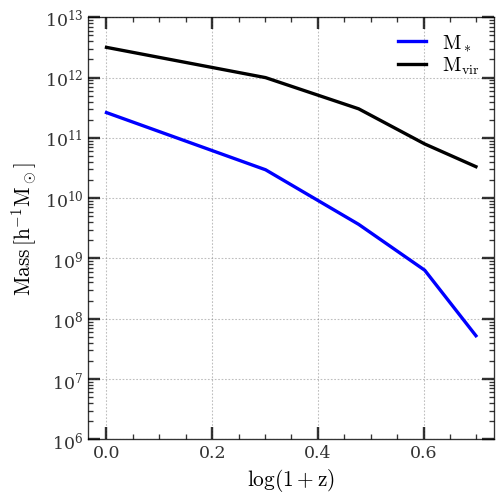

In [9]:
def show_stellar_mass_history(tree_out):
    m_s, m_h, z, leaf_id, id = tree_out['m_s', 'm_h', 'z', 'leaf_id', 'id']
    
    b = 0
    e = leaf_id[b] - id[b] + 1
    z = z[b:e]
    m_s = m_s[b:e] * 1.0e10      # to h^{-1} M_sun
    m_h = m_h[b:e] * 1.0e10
    
    fig, ax = plot.subplots(1, figsize=5.5)

    ax.c('b').plot(np.log10(1.0+z), m_s, label=r'$M_*$')\
        .c('k').plot(np.log10(1.0+z), m_h, label=r'$M_{\rm vir}$')\
        
    ax.scale(y='log')\
        .label(r'\log(1+z)', r'Mass\, [h^{-1} M_\odot]')\
        .lim(y=[1.0e6, 1.0e13])\
        .leg()
        
show_stellar_mass_history(tree_out)

## A realistic example

Here we show a more realistic example where we work on a merger tree taken
from the IllustrisTNG100-1-Dark simulation.

The data is donwloaded from "https://www.tng-project.org/", and we have 
converted them into a HDF5 file containing data required by our model.

The data is a subhalo merger tree rooted in a subhalo with 
`SubhaloID=30000308700000000` (see IllustrisTNG's doc, sometimes this ID is 
also called SubLinkID). The halo mass of the root subhalo is about $10^{11} h^{-1} M_\odot$.

To quickly view the file contents, we use the `pyhipp.io.h5` module:

In [10]:
file_name = 'example_data/example_tree.hdf5'
h5.File.ls_from(file_name)

/
├─ cosmology_params/
   ├─ hubble(float64)
   ├─ n_spec(float64)
   ├─ omega_b0(float64)
   ├─ omega_l0(float64)
   ├─ omega_m0(float64)
   ├─ sigma_8(float64)
   └─ t_cmb(float64)
└─ subhalos/
   ├─ id(int64, (1005,))
   ├─ is_cent(bool, (1005,))
   ├─ last_pro_id(int64, (1005,))
   ├─ leaf_id(int64, (1005,))
   ├─ m_h(float32, (1005,))
   ├─ snap(int16, (1005,))
   ├─ v_max(float32, (1005,))
   └─ z(float64, (1005,))


The file contains subhalos in the merger tree, as well as 
the cosmological parameters used in the simulation.

To load the data, call `load_from()`. It returns a dict-like 
object, whose values can be accessed by keys:

In [11]:
cosm_ps, subhalos = h5.File.load_from(file_name)[
    'cosmology_params', 'subhalos']

We convert the data to the format that the model expects, and run the model:

In [12]:
cosm = LambdaCDM.from_parameters(cosm_ps)
data_in = tpgm.samples.make_group_tree_from_dict(subhalos, cosm=cosm)

model = tpgm.model.GroupTreeBatchGalaxy()
model.set_up()

data_out = model([data_in])
tree_out = data_out.grptrs[0]

We again show the mass histories of the main branch:

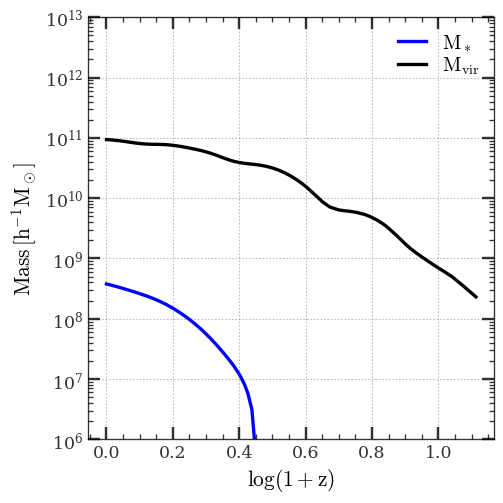

In [13]:
show_stellar_mass_history(tree_out)